In [1]:
%matplotlib inline
import scipy.integrate as si
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from matplotlib import animation, rc
rc('animation', html='jshtml')
import pandas as pd

from IPython.display import set_matplotlib_formats

#set_matplotlib_formats("png")
plt.rc("xtick", labelsize=5, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=5, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure",figsize=(5,3),dpi=250) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

In [16]:
data_columns = ["IonNumber", "IonTOF [s]", "Mass [au]", "Charge [e]",
                "x [mm]", "y [mm]", "z [mm]", "px [mm/mics]", "py [mm/mics]", "pz [mm/mics]"]  
# mics er micro sekunder
header_columns = ["IonEnergy [eV]", "IonMass [au]", "IonCharge [e]", "FragmentMass [au]", "FragmentCharge [e]",
         "ElectronMass [au]", "ElectronCharge [e]", "EkinRelease [eV]", "Asym Beta", "Dissociation Constant",
         "Wavelength [nm]", "IonBeamPropagation x", "IonBeamPropagation y", "IonBeamPropagation z",
          "UNKNOWN", "UNKNOWN", "UNKNOWN", "UNKNOWN", "UNKNOWN", "UNKNOWN"]

def load_file(file: str, data_cols: list = data_columns, 
              header_cols: list = header_columns) -> (pd.DataFrame, pd.DataFrame):
    
    header_data = np.loadtxt("data/MMRUN_167.dat", skiprows=1, max_rows=2)
    header_data = np.concatenate(header_data)
    df_header = pd.DataFrame(data=pd.DataFrame(data=header_data).T.values, columns=header_cols)
    
    data = np.loadtxt("data/MMRUN_167.dat", skiprows=3)
    df = pd.DataFrame(data=data, columns=data_cols)
    
    return df, df_header

IonBeamPropagation er plarizering så er 1 er 0 hvis 1 er det x polariseret lys

In [17]:
# Natural constants
c = 2.99792458e8
Qe = 1.602176634e-19
AMU = 931.4908918e6 / (c ** 2) * Qe
me = 1822.8885
ao = 0.529177
to = 2.41889e-17
kBoltz = 3.168140552e-6
au2eV = 27.2113961
eV2au = 1 / au2eV
eV2cm = 8065.5409
cm2eV = 1 / eV2cm
mm_microsec2m_sec = 1000


In [18]:
detector_coor_y = 1150 
start_ion_y = 603
# TOF bins 0 til 50 000 

In [19]:
df_raw, df_header = load_file("data/MMRUN_167.dat")

In [20]:
df_header

,IonEnergy [eV],IonMass [au],IonCharge [e],FragmentMass [au],FragmentCharge [e],ElectronMass [au],ElectronCharge [e],EkinRelease [eV],Asym Beta,Dissociation Constant,Wavelength [nm],IonBeamPropagation x,IonBeamPropagation y,IonBeamPropagation z,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
0,3000.0,16.0,-1.0,16.0,-1.0,0.000549,-1.0,0.065,0.0,0.0,355.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_raw

,IonNumber,IonTOF [s],Mass [au],Charge [e],x [mm],y [mm],z [mm],px [mm/mics],py [mm/mics],pz [mm/mics]
0,1.0,2.100001,0.000100,75.0,1.500010,0.00000,0.000000,0.00000,0.000000,0.000000
1,1.0,0.000000,16.000000,-1.0,1.000000,601.64670,1.550921,190.21561,0.000214,-0.000245
2,1.0,-100.000000,0.000000,-1.0,0.065000,0.00000,0.000000,0.00000,0.000000,0.000000
3,1.0,0.386140,16.000000,-1.0,74.492312,601.64677,1.547363,190.64304,-0.025085,-0.052725
4,1.0,0.777602,16.000000,-1.0,149.000000,601.62601,1.510969,190.21802,-0.053384,-0.102417
...,...,...,...,...,...,...,...,...,...,...
7996,1999.0,0.777610,16.000000,-1.0,149.000000,602.47194,-1.359045,190.21435,-0.000768,0.092621
7997,2000.0,0.000000,16.000000,-1.0,1.000000,602.47221,-1.395163,190.21561,0.000083,0.000221
7998,2000.0,-100.000000,0.000000,1999.0,0.065000,0.00000,0.000000,0.00000,0.000000,0.000000
7999,2000.0,0.389395,0.000549,-1.0,75.112827,602.47221,-1.391823,226.21605,-54.983506,-136.246410


### What to plot ?

qut fra mindre end terskel i y 

In [9]:
cut_y_top = 1156
cut_y_bot = - 142 + 0.001
#sort = df_raw.loc[(df["y [mm]"] < cut_y_bot)]# & (df["y [mm]"] != - 0)].copy()

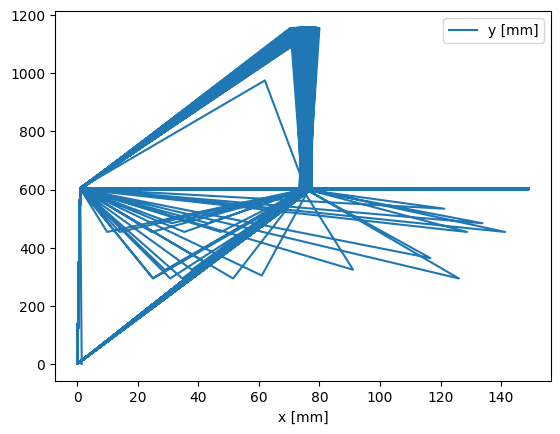

In [10]:
df_raw.plot(x="x [mm]", y="y [mm]")
plt.show()

In [14]:
df_raw

,IonNumber,IonTOF [s],Mass [au],Charge [e],x [mm],y [mm],z [mm],px [mm/usec],py [mm/mics],pz [mm/mics]
0,1.0,2.100001,0.000100,75.0,1.500010,0.00000,0.000000,0.00000,0.000000,0.000000
1,1.0,0.000000,16.000000,-1.0,1.000000,601.64670,1.550921,190.21561,0.000214,-0.000245
2,1.0,-100.000000,0.000000,-1.0,0.065000,0.00000,0.000000,0.00000,0.000000,0.000000
3,1.0,0.386140,16.000000,-1.0,74.492312,601.64677,1.547363,190.64304,-0.025085,-0.052725
4,1.0,0.777602,16.000000,-1.0,149.000000,601.62601,1.510969,190.21802,-0.053384,-0.102417
...,...,...,...,...,...,...,...,...,...,...
7996,1999.0,0.777610,16.000000,-1.0,149.000000,602.47194,-1.359045,190.21435,-0.000768,0.092621
7997,2000.0,0.000000,16.000000,-1.0,1.000000,602.47221,-1.395163,190.21561,0.000083,0.000221
7998,2000.0,-100.000000,0.000000,1999.0,0.065000,0.00000,0.000000,0.00000,0.000000,0.000000
7999,2000.0,0.389395,0.000549,-1.0,75.112827,602.47221,-1.391823,226.21605,-54.983506,-136.246410


In [23]:
# Constants from original code
AMU = 931.4908918e6 / (2.99792458e8**2) * 1.602176634e-19  # AMU in eV s²/m²
Qe = 1.602176634e-19  # Elementary charge in coulombs
mm_microsec2m_sec = 1000  # Conversion factor for velocities

# Midpoints (replace with values)
Xmid = 75 * 1 + 0.0  # Midpoint in X-axis (mm)
Ymid = 150 * 0  # Midpoint in Y-axis (mm)
Zmid = 75 * 0  # Midpoint in Z-axis (mm)

df = pd.DataFrame()

# Update df fields with calculated values using vectorized operations
df['Ion_Mass'] = df_raw['Mass [au]'] * AMU  # Convert mass to eV s²/m²
df['Ion_Charge'] = df_raw['Charge [e]'] * Qe  # Convert charge to coulombs

# Convert x, y, z from mm to m and adjust for midpoints
df['Ion_X'] = (df_raw['x [mm]'] - Xmid) * 1e-3
df['Ion_Y'] = (df_raw['y [mm]'] - Ymid) * 1e-3
df['Ion_Z'] = (df_raw['z [mm]'] - Zmid) * 1e-3

# Convert velocities from mm/usec to m/s
df['Ion_Vx'] = df_raw['px [mm/mics]'] * mm_microsec2m_sec
df['Ion_Vy'] = df_raw['py [mm/mics]'] * mm_microsec2m_sec
df['Ion_Vz'] = df_raw['pz [mm/mics]'] * mm_microsec2m_sec

# Compute total energy of ions
df['Ion_E'] = 0.5 * df['Ion_Mass'] * (df['Ion_Vx']**2 + df['Ion_Vy']**2 + df['Ion_Vz']**2)

# Compute total velocity
df['Ion_Vtotal'] = np.sqrt(df['Ion_Vx']**2 + df['Ion_Vy']**2 + df['Ion_Vz']**2)

# Compute radial distances (R) and radial velocities (Vr)
df['Ion_R'] = np.sqrt(df['Ion_Y']**2 + df['Ion_Z']**2)
df['Ion_Vr'] = np.sqrt(df['Ion_Vy']**2 + df['Ion_Vz']**2)

# Calculate center of mass velocities for Fragment 1
df['F1_i_Vx_CM'] = df['Ion_Vx'] - df['Ion_Vx']  # This needs to be modified per fragment
df['F1_i_Vy_CM'] = df['Ion_Vy'] - df['Ion_Vy']  # Correct the logic for CM velocities
df['F1_i_Vz_CM'] = df['Ion_Vz'] - df['Ion_Vz']
df['F1_i_Vo_CM'] = np.sqrt(df['F1_i_Vx_CM']**2 + df['F1_i_Vy_CM']**2 + df['F1_i_Vz_CM']**2)

# Calculate CM angle
df['F1_i_theta_CM'] = np.arccos(df['F1_i_Vx_CM'] / df['F1_i_Vo_CM'])

# Similarly handle fragment 2 or any other fragments


In [26]:
all_data = np.loadtxt("data/MMRUN_167.dat", skiprows=3)

In [54]:
nr = 4 
number_index = 0

all_data[1:40:nr, number_index]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [52]:
df_raw[["IonNumber","Mass [au]"]].groupby(by="IonNumber").count().describe()

,Mass [au]
count,2000.000000
mean,4.000500
std,0.022361
min,4.000000
25%,4.000000
50%,4.000000
75%,4.000000
max,5.000000


Struktur:
1: Ion
2: ??
3: F1
4: 

